# Notebook para o PAN - Atribuição Autoral - 2018

In [1]:
%matplotlib inline
#python basic libs
from __future__ import print_function

from tempfile import mkdtemp
from shutil import rmtree
import os;
from os.path import join as pathjoin;

import re;
import glob;
import json;
import codecs;
from collections import defaultdict;
import pprint;


from pprint import pprint
from time import time
import logging


#data analysis libs
import numpy as np;
import pandas as pd;
import matplotlib.pyplot as plt;
import random;

#machine learning libs
#feature extraction
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

#preprocessing and transformation
from sklearn.preprocessing import normalize, MaxAbsScaler, MinMaxScaler;
from sklearn.preprocessing import LabelBinarizer;
from sklearn.decomposition import PCA;
from sklearn.metrics.pairwise import cosine_similarity;


from sklearn.base import BaseEstimator, ClassifierMixin

#classifiers
from sklearn.svm import LinearSVC, SVC
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

from sklearn.feature_selection import RFE,SelectFpr,SelectPercentile, chi2;

#
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier
from sklearn.ensemble import VotingClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

#model valuation
from sklearn.model_selection import train_test_split;
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, accuracy_score;

In [2]:
import platform; print(platform.platform())
print("NumPy", np.__version__)
import scipy; print("SciPy", scipy.__version__)
import sklearn; print("Scikit-Learn", sklearn.__version__)

Darwin-17.4.0-x86_64-i386-64bit
NumPy 1.14.0
SciPy 1.0.0
Scikit-Learn 0.19.1


### paths configuration

In [3]:
baseDir = '/Users/joseeleandrocustodio/Dropbox/mestrado/02 - Pesquisa/code';

inputDir= pathjoin(baseDir,'pan18aa');
outputDir= pathjoin(baseDir,'out',"oficial");
if not os.path.exists(outputDir):
    os.mkdir(outputDir);

## loading the dataset

In [4]:
def readCollectionsOfProblems(path):
    # Reading information about the collection
    infocollection = path+os.sep+'collection-info.json'
    with open(infocollection, 'r') as f:
        problems  = [
            {
                'problem': attrib['problem-name'],
                'language': attrib['language'],
                'encoding': attrib['encoding'],
            }
            for attrib in json.load(f)
            
        ]
    return problems;

In [5]:
problems = readCollectionsOfProblems(inputDir);

In [6]:
problems[0]

{'encoding': u'UTF-8', 'language': u'en', 'problem': u'problem00001'}

In [7]:
def readProblem(path, problem):
    # Reading information about the problem
    infoproblem = path+os.sep+problem+os.sep+'problem-info.json'
    candidates = []
    with open(infoproblem, 'r') as f:
        fj = json.load(f)
        unk_folder = fj['unknown-folder']
        for attrib in fj['candidate-authors']:
            candidates.append(attrib['author-name'])
    return unk_folder, candidates;

In [8]:
def read_files(path,label):
    # Reads all text files located in the 'path' and assigns them to 'label' class
    files = glob.glob(pathjoin(path,label,'*.txt'))
    texts=[]
    for i,v in enumerate(files):
        f=codecs.open(v,'r',encoding='utf-8')
        texts.append((f.read(),label, os.path.basename(v)))
        f.close()
    return texts

In [9]:
for index,problem in enumerate(problems):
    unk_folder, candidates_folder = readProblem(inputDir, problem['problem']); 
    problem['candidates_folder_count'] = len(candidates_folder);
    problem['candidates'] = [];
    for candidate in candidates_folder:
        problem['candidates'].extend(read_files(pathjoin(inputDir, problem['problem']),candidate));
    
    problem['unknown'] = read_files(pathjoin(inputDir, problem['problem']),unk_folder);    

In [10]:
pd.DataFrame(problems)

,candidates,candidates_folder_count,encoding,language,problem,unknown
0,"[(graceful ones.\n\n""One more,"" Marvelous said...",20,UTF-8,en,problem00001,"[(after all, his best friends. And what in the..."
1,"[(a mission.""\n\nJensen just raises an eyebrow...",5,UTF-8,en,problem00002,"[(“Potter was attractive,” Draco thought, sigh..."
2,[(qui l'avait tué mais tout était de la faute ...,20,UTF-8,fr,problem00003,[(son réveil. Sa main pulse et Draco frotte l'...
3,[(. Le canapé est vide et lorsqu'il passe deva...,5,UTF-8,fr,problem00004,"[(abasourdie.\n\nTout d'abord, elle crut que s..."
4,"[(Eppure lui la mappa l’aveva stampata, dannaz...",20,UTF-8,it,problem00005,[(– Oh. Cazzo.\nSirius era così sconvolto che ...
5,[(Yato ha trovato una lettera sul suo comodino...,5,UTF-8,it,problem00006,"[(così la tua vista, Moony?\n– Cercavo di esse..."
6,[(zmienił zdanie. Niech się stworzonko pobawi....,20,UTF-8,pl,problem00007,"[(dawniej pełna radości i ciepła, a teraz wiec..."
7,"[(Słowem, które Sherlock najczęściej słyszał w...",5,UTF-8,pl,problem00008,"[(, uderzającego o żebra niczym dzwon- niemal ..."
8,[(pero no lo ama como ama a Guignol –explicó e...,20,UTF-8,sp,problem00009,[(–La nariz puntiaguda del elfo casi rozaba el...
9,"[(incapaz de señalar un momento exacto, un pun...",5,UTF-8,sp,problem00010,[(tan parecidas hizo que su trasero latiese de...


In [11]:
#*******************************************************************************************************
import warnings
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.preprocessing import LabelEncoder


def eval_measures(gt, pred):
    """Compute macro-averaged F1-scores, macro-averaged precision, 
    macro-averaged recall, and micro-averaged accuracy according the ad hoc
    rules discussed at the top of this file.
    Parameters
    ----------
    gt : dict
        Ground truth, where keys indicate text file names
        (e.g. `unknown00002.txt`), and values represent
        author labels (e.g. `candidate00003`)
    pred : dict
        Predicted attribution, where keys indicate text file names
        (e.g. `unknown00002.txt`), and values represent
        author labels (e.g. `candidate00003`)
    Returns
    -------
    f1 : float
        Macro-averaged F1-score
    precision : float
        Macro-averaged precision
    recall : float
        Macro-averaged recall
    accuracy : float
        Micro-averaged F1-score
    """

    actual_authors = list(gt.values())
    encoder = LabelEncoder().fit(['<UNK>'] + actual_authors)

    text_ids, gold_authors, silver_authors = [], [], []
    for text_id in sorted(gt):
        text_ids.append(text_id)
        gold_authors.append(gt[text_id])
        try:
            silver_authors.append(pred[text_id])
        except KeyError:
            # missing attributions get <UNK>:
            silver_authors.append('<UNK>')

    assert len(text_ids) == len(gold_authors)
    assert len(text_ids) == len(silver_authors)

    # replace non-existent silver authors with '<UNK>':
    silver_authors = [a if a in encoder.classes_ else '<UNK>' 
                      for a in silver_authors]

    gold_author_ints   = encoder.transform(gold_authors)
    silver_author_ints = encoder.transform(silver_authors)

    # get F1 for individual classes (and suppress warnings):
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        f1 = f1_score(gold_author_ints,
                  silver_author_ints,
                  labels=list(set(gold_author_ints)),
                  average='macro')
        precision = precision_score(gold_author_ints,
                  silver_author_ints,
                  labels=list(set(gold_author_ints)),
                  average='macro')
        recall = recall_score(gold_author_ints,
                  silver_author_ints,
                  labels=list(set(gold_author_ints)),
                  average='macro')
        accuracy = accuracy_score(gold_author_ints,
                  silver_author_ints)

    return f1,precision,recall,accuracy


In [12]:
def evaluate(ground_truth_file,predictions_file):
    # Calculates evaluation measures for a single attribution problem
    gt = {}
    with open(ground_truth_file, 'r') as f:
        for attrib in json.load(f)['ground_truth']:
            gt[attrib['unknown-text']] = attrib['true-author']

    pred = {}
    with open(predictions_file, 'r') as f:
        for attrib in json.load(f):
            if attrib['unknown-text'] not in pred:
                pred[attrib['unknown-text']] = attrib['predicted-author']
    f1,precision,recall,accuracy =  eval_measures(gt,pred)
    return f1, precision, recall, accuracy

In [13]:
from sklearn.base import BaseEstimator
from scipy.sparse import issparse


class DenseTransformer(BaseEstimator):
    """Convert a sparse array into a dense array."""

    def __init__(self, return_copy=True):
        self.return_copy = return_copy
        self.is_fitted = False

    def transform(self, X, y=None):
        """ Return a dense version of the input array.
        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_samples, n_features]
            Training vectors, where n_samples is the number of samples and
            n_features is the number of features.
        y : array-like, shape = [n_samples] (default: None)
        Returns
        ---------
        X_dense : dense version of the input X array.
        """
        if issparse(X):
            return X.toarray()
        elif self.return_copy:
            return X.copy()
        else:
            return X

    def fit(self, X, y=None):
        """ Mock method. Does nothing.
        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_samples, n_features]
            Training vectors, where n_samples is the number of samples and
            n_features is the number of features.
        y : array-like, shape = [n_samples] (default: None)
        Returns
        ---------
        self
        """
        self.is_fitted = True
        return self

    def fit_transform(self, X, y=None):
        """ Return a dense version of the input array.
        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_samples, n_features]
            Training vectors, where n_samples is the number of samples and
            n_features is the number of features.
        y : array-like, shape = [n_samples] (default: None)
        Returns
        ---------
        X_dense : dense version of the input X array.
        """
        return self.transform(X=X, y=y)

In [19]:
def runML(problem):
    print ("Problem: %s,  language: %s, " %(problem['problem'],problem['language']))
    
    train_docs, train_labels, _   = zip(*problem['candidates'])
    problem['training_docs_size'] = len(train_docs);
    test_docs, _, test_filename   = zip(*problem['unknown'])
    
    cachedir = mkdtemp()
    pipeline = Pipeline([
        ('vect',   TfidfVectorizer(analyzer='char',max_df=1.0, ngram_range=(2,5), lowercase=False, norm='l2', sublinear_tf=True)),
        ('dense',  DenseTransformer()),
        ('scaler', MinMaxScaler()),
        ('transf', PCA(0.95)),
        ('clf', LogisticRegression(random_state=0,multi_class='multinomial', solver='newton-cg')),
    ], memory=cachedir)
    
    
    # uncommenting more parameters will give better exploring power but will
    # increase processing time in a combinatorial way
    parameters = {
        'vect__min_df': (0.05, 0.25, 0.5, 0.75),
    }
    
    grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1)
    
    print("Performing grid search...")
    t0 = time()
    grid_search.fit(train_docs, train_labels)
    print("done in %0.3fs \n" % (time() - t0))

    print("Best score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))
        
    #pipeline.set_params(best_parameters);
    pipeline.fit(train_docs, train_labels);
    
    train_pred=grid_search.predict(train_docs);
    test_pred=grid_search.predict(test_docs);
    
    
    # Writing output file
    out_data=[]
    for i,v in enumerate(test_pred):
        out_data.append(
                {'unknown-text': test_filename[i],
                 'predicted-author': v
                }
                )
    answerFile = pathjoin(outputDir,'answers-'+problem['problem']+'.json');
    with open(answerFile, 'w') as f:
        json.dump(out_data, f, indent=4)
        #allProblems.extend(out_data)
    
    
    #evaluation train
    f1,precision,recall,accuracy=evaluate(
                pathjoin(inputDir, problem['problem'], 'ground-truth.json'),
                answerFile)
    rmtree(cachedir)
    return {
                'problem-name'   : problem['problem'],
                "train_doc_size":len(train_docs),
                "language":problem['language'],
                'macro-f1'       : round(f1,3),
                'macro-precision': round(precision,3),
                'macro-recall'   : round(recall,3),
                'micro-accuracy' : round(accuracy,3),
                'AuthorCount':len(set(train_labels))
        };

In [20]:
result = [];
for problem in problems:
    result.append(runML(problem));
pd.DataFrame(result)

Problem: problem00001,  language: en, 
Performing grid search...
Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:   43.0s finished


done in 49.526s 

Best score: 0.793
Best parameters set:
	vect__min_df: 0.05
Problem: problem00002,  language: en, 
Performing grid search...
Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:   17.1s finished


done in 20.373s 

Best score: 0.971
Best parameters set:
	vect__min_df: 0.05
Problem: problem00003,  language: fr, 
Performing grid search...
Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:   50.7s finished


done in 57.453s 

Best score: 0.779
Best parameters set:
	vect__min_df: 0.05
Problem: problem00004,  language: fr, 
Performing grid search...
Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:   17.9s finished


done in 21.435s 

Best score: 0.857
Best parameters set:
	vect__min_df: 0.05
Problem: problem00005,  language: it, 
Performing grid search...
Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:   54.8s finished


done in 61.993s 

Best score: 0.686
Best parameters set:
	vect__min_df: 0.05
Problem: problem00006,  language: it, 
Performing grid search...
Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:   21.7s finished


done in 25.692s 

Best score: 0.943
Best parameters set:
	vect__min_df: 0.05
Problem: problem00007,  language: pl, 
Performing grid search...
Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:  1.2min finished


done in 79.865s 

Best score: 0.807
Best parameters set:
	vect__min_df: 0.05
Problem: problem00008,  language: pl, 
Performing grid search...
Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:   28.6s finished


done in 33.932s 

Best score: 0.829
Best parameters set:
	vect__min_df: 0.05
Problem: problem00009,  language: sp, 
Performing grid search...
Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:  1.0min finished


done in 69.274s 

Best score: 0.871
Best parameters set:
	vect__min_df: 0.05
Problem: problem00010,  language: sp, 
Performing grid search...
Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:   21.1s finished


done in 25.747s 

Best score: 0.886
Best parameters set:
	vect__min_df: 0.05


,AuthorCount,language,macro-f1,macro-precision,macro-recall,micro-accuracy,problem-name,train_doc_size
0,20,en,0.592,0.569,0.726,0.619,problem00001,140
1,5,en,0.590,0.607,0.667,0.571,problem00002,35
2,20,fr,0.681,0.664,0.742,0.735,problem00003,140
3,5,fr,0.719,0.766,0.753,0.667,problem00004,35
4,20,it,0.634,0.644,0.729,0.713,problem00005,140
5,5,it,0.623,0.630,0.668,0.783,problem00006,35
6,20,pl,0.445,0.455,0.531,0.495,problem00007,140
7,5,pl,1.000,1.000,1.000,1.000,problem00008,35
8,20,sp,0.768,0.783,0.816,0.786,problem00009,140
9,5,sp,0.789,0.792,0.794,0.859,problem00010,35


In [17]:
pd.DataFrame(result)[['macro-f1']].describe()

,macro-f1
count,10.000000
mean,0.704400
std,0.126125
min,0.519000
25%,0.620750
50%,0.681500
75%,0.827250
max,0.867000


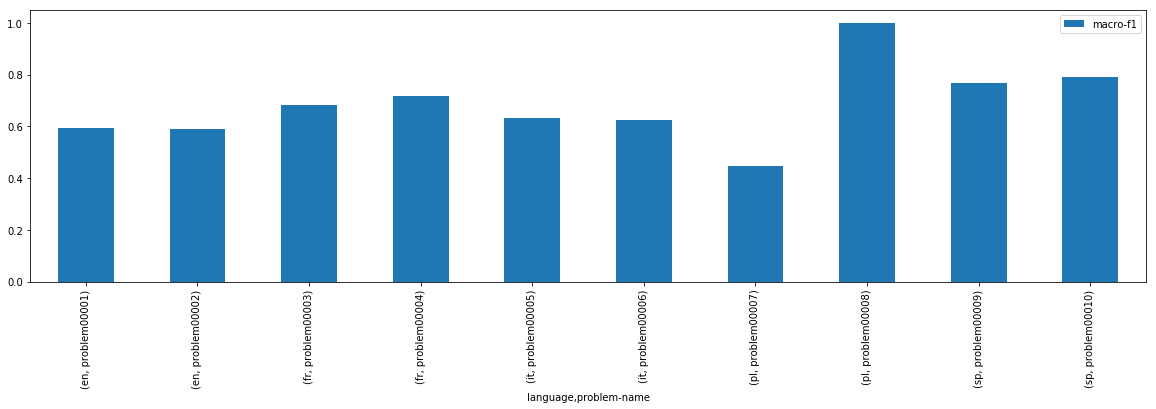

In [21]:
pd.DataFrame(result)\
    .sort_values(by=['language','problem-name'])[['language','problem-name','macro-f1']]\
    .plot(kind='bar', x=['language','problem-name'], legend=True, figsize=(20,5))

<br/><br/><br/><br/><br/>

#  Abordagem desafiante 1

In [ ]:
from gensim.models import Word2Vec;

In [ ]:
class NgramSplitter(object):
    def __init__(self, text, ngram=(3,3), vocabulary=None):
        self.text = text
        self.ngram_min = ngram[0]
        self.ngram_max = ngram[1];
        self.vocabulary = vocabulary;
    
    def text2ngrams(self,text):
        vect = [
            text[t:t+j]
                for t in xrange(len(text)-self.ngram_max+1)
                for j in xrange(self.ngram_min, self.ngram_max+1)
        ]
        
        if self.vocabulary is not None:
            return [word for word in vect if word in self.vocabulary];
        else:
            return [word for word in vect if word]
 
    def __iter__(self):
        if isinstance(self.text,list):
            for s in self.text:
                yield self.text2ngrams(s);
        elif isinstance(self.text,str) or isinstance(self.text,unicode):
            yield self.text2ngrams(self.text);

In [ ]:
class Word2VecClassifier(BaseEstimator, ClassifierMixin):  
    """A classifier that uses classes embeddings to classify instances"""
    
    def __init__(
            self,
            ngram = (3,4),
            analyzer = 'char',
            min_df = 0.3,
            max_df = 1.0,
        
            min_count =2,
            embeddingSize =750,
            window=10,
            algorithm = 0,
            iter =10
        ):
        """
        Called when initializing the classifier
        """
        self.algorithm     = algorithm
        self.min_count     = min_count
        self.embeddingSize = embeddingSize
        self.window        = window
        self.iter          = iter
        self.analyzer      = analyzer
        self.vocabulary_   = {}
        self.ngram         = ngram
        self.min_df        = min_df
        self.max_df        = max_df

    def _buildVectorModel(self, document):
        sentenseGenerator = NgramSplitter(document,self.ngram, self.vocabulary_);
        
        model = Word2Vec(
            sentenseGenerator,
            sg       = self.algorithm,
            iter     = self.iter,        
            min_count= self.min_count,
            window   = self.window,
            size     = self.embeddingSize,
            seed=0
        );
        return model.wv;
        
    def fit(self, X, y=None):
        """
        Sumarize one text per labels and transform the text into word vectors
        """
        
        #creating author profile
        profile = defaultdict(unicode);
        for text, label in zip(X,y):
            profile[label]+=text;
            
        #build a global vocaculary / Using count vectorizer to create a fixed vocabulary
        vectorizer = CountVectorizer(
                analyzer=self.analyzer,
                ngram_range=self.ngram,
                min_df=self.min_df,
                max_df=self.max_df,
                lowercase=False
        )
        vectorizer.fit(X);
        self.vocabulary_ = vectorizer.vocabulary_
        
        # profile vector represent each author in the embedding space
        self.profileVectors_ = {y: self._buildVectorModel(profile[y]) for y in y};

        return self
    
    
    def _minmax(self, a):
        a = (a - a.min())/(a.max() - a.min());
        return a;
        
    def _simpleCosine(self,a, b):
        '''
        calculates cosine between array a and b.
        This function is used because sklearn similiraty function compares all elements vs all elements
        what will not be used. So this function becames handy.
        '''
        a = a / np.sqrt(np.sum(a **2));
        b = b / np.sqrt(np.sum(b **2));
        cos = np.sum(np.array(a) * np.array(b));
        return cos;
    
    def _KLD(self,p, q):
        p = self._minmax(p); p = p/p.sum();
        q = self._minmax(q); q = q/q.sum();
        
        cond = ((q != 0)&(p != 0));
        k1 = np.sum(np.where(cond, p * np.log(p / q), 0));
        return k1;
    
    def _manhattan(self,p, q):
        p = self._minmax(p); p = p/p.sum();
        q = self._minmax(q); q = q/q.sum();
        return np.mean(np.abs(p-q));
    
    
    def _guassian(self, C,D):
        cond = C-D !=0;
        bc = np.where(cond,(C-D+1)**2/(2*np.maximum(C,D+1)),1);
        return np.sum(-np.log(bc));


    def score(self, X, y=None):
        # counts number of values bigger than mean
        return(sum(self.predict(X)))
    
    def _softMax(self,a):
        a = self._minmax(a);
        a = np.exp(a)/np.sum(np.exp(a))
        return a;
    
    def _predict1Doc(self, docVect):
        vocabDoc = set(docVect.vocab.keys());
    
        metrics = [];
        
        def c(aa,bb, funct):
            voc = set(aa.vocab.keys()) & set(bb.vocab.keys())
            f = np.array([
                funct(aa[v], bb[v])
                for v in voc
            ]);
            f = np.sum(f)
            return f;
    
        for label in self.profileVectors_:
            labelVocab = set(self.profileVectors_[label].vocab.keys());
            intersect  = vocabDoc & labelVocab;
            union      = len(vocabDoc | labelVocab);
            jaccard    = 1.0*len(intersect) / union;
            
            metrics.append({
                'label'       : label,
                'jaccard'     : jaccard,
                'lenIntersect': len(intersect),
                'lenUnion'    : union,
                'lenMax'      : max(len(labelVocab), len(vocabDoc)),
                'similarity'  : c(docVect, self.profileVectors_[label], self._simpleCosine),
                'KLD'         : c(docVect, self.profileVectors_[label], self._KLD),
                'manhattan'   : c(docVect, self.profileVectors_[label], self._manhattan),
                'guassian'    : c(docVect, self.profileVectors_[label], self._guassian),
                
            })
        #softmax norm
        similarity = self._softMax(np.array([c['similarity'] for c in metrics ]));
        guassian   = self._softMax(np.array([c['guassian'] for c in metrics ]));
        manhattan  = self._softMax(np.array([c['manhattan'] for c in metrics ]));
    
        #appending normalized sum of distance
        for i,c in enumerate(metrics):
            c.update({
                'similarityNorm': similarity[i],
                'guassianNorm': guassian[i],
                'manhattanNorm': manhattan[i]
            })
    
        return metrics;
    
    def predict(self, X, y=None):
        try:
            getattr(self, "profileVectors_")
        except AttributeError:
            raise RuntimeError("You must train classifer before predicting data!")
            
        docVectors    = [self._buildVectorModel(x) for x in X];
        self.metrics_ = [self._predict1Doc(v)      for v in docVectors];
        
        result = [];
        for r in self.metrics_:
            best = r[0];
            best['bestMatch'] = True;
            for rr in r:
                if rr != best:
                    rr['bestMatch'] = False;
                if rr['similarityNorm'] > best['similarityNorm'] :
                    best['bestMatch'] = False;
                    best = rr;
                    best['bestMatch'] = True;
            result.append(best);
            
        self.predited_ = result;

        return([r['label'] for r in result])

In [ ]:
problem = problems[8];
print ("Problem: %s,  language: %s, " %(problem['problem'],problem['language']))

In [ ]:
model = Word2VecClassifier();

In [ ]:
train_docs, train_labels,_ = zip(*problem['candidates']);

In [ ]:
model.fit(train_docs,train_labels);

In [ ]:
trainPred = model.predict(train_docs);
trainMetrics = model.metrics_;

In [ ]:
df=pd.DataFrame(zip(train_labels,trainPred), columns=['label','pred'])
df.label = df.label.apply(lambda x: int(re.sub(r'\D','',x)));
df.pred = df.pred.apply(lambda x: int(re.sub(r'\D','',x)));
df.plot.scatter(x='label',y='pred');

In [ ]:
m  = trainMetrics
df = pd.DataFrame([item for s in m for item in s])
df['doc']      = [i               for i,s in enumerate(m) for item in s]
df['solution'] = [train_labels[i] for i,s in enumerate(m) for item in s]
df.sort_values(by=['doc','similarityNorm', 'manhattan'], ascending=[True,False,True], inplace=True)
df['distance'] = [i for i in range(len(set(train_labels)))]* len(trainMetrics)
df[df.doc == 55]

In [ ]:
df2 = df[df.bestMatch].copy();
df2['correct'] = df2.apply(lambda x: x['label'] == x['solution'], axis=1)
df2[['correct','doc']].groupby(by='correct').count()

In [ ]:
model.get_params()

In [ ]:
df2 = df[df.bestMatch].copy();
df2['correct'] = df2.apply(lambda x: x['label'] == x['solution'], axis=1)
df2[['correct','doc']].groupby(by='correct').count()

In [ ]:
model.get_params()

In [ ]:
df[df.solution == df.label].plot.scatter(x='distance', y='manhattanNorm')
df[df.solution == df.label].plot.scatter(x='distance', y='guassianNorm')
df[df.solution == df.label].plot.scatter(x='distance', y='similarityNorm')
df[df.solution == df.label].plot.scatter(x='manhattanNorm', y='guassianNorm', c='distance',colormap='Reds')

### test

In [ ]:
#code from baseline
gt = {}
with open(pathjoin(inputDir, problem['problem'], 'ground-truth.json'), 'r') as f:
    for attrib in json.load(f)['ground_truth']:
        gt[attrib['unknown-text']] = attrib['true-author']

In [ ]:
test_docs, _, test_filename = zip(*problem['unknown'])
test_labels = [gt[v] for v in test_filename]

In [ ]:
testPred = model.predict(test_docs);
testMetrics = model.metrics_;

In [ ]:
m  = testMetrics
df = pd.DataFrame([item for s in m for item in s])
df['doc']      = [i               for i,s in enumerate(m) for item in s]
df['solution'] = [train_labels[i] for i,s in enumerate(m) for item in s]
df.sort_values(by=['doc','similarityNorm', 'KLD'], ascending=[True,False,True], inplace=True)
df['distance'] = [i for i in range(len(set(train_labels)))]* len(testMetrics)
df[df.doc == 55]

In [ ]:
f1,precision,recall,accuracy =  eval_measures(gt,{k: v for k,v in zip(test_filename, testPred)  })

In [ ]:
pd.DataFrame([{
                'macro-f1'       : round(f1,3),
                'macro-precision': round(precision,3),
                'macro-recall'   : round(recall,3),
                'micro-accuracy' : round(accuracy,3)
             }])

In [ ]:
df2 = df[df.bestMatch].copy();
df2['correct'] = df2.apply(lambda x: x['label'] == x['solution'], axis=1)
df2[['correct','doc']].groupby(by='correct').count()

In [ ]:
df[df.solution == df.label].plot.scatter(x='distance', y='guassianNorm')
df[df.solution == df.label].plot.scatter(x='distance', y='manhattanNorm')
df[df.solution == df.label].plot.scatter(x='distance', y='similarityNorm')

In [ ]:
df[df.solution == df.label]\
    .plot\
    .scatter(
        x='guassianNorm',
        y='similarityNorm',
        c='distance',
        colormap='Reds',
        figsize=(20,5));